## Air Temperature Calibration Model Development 

**Hong Tang Nov5,2021**  

**Task Description**

**Goal:** \
    The goal of a calibration model is to improve the accuracy and reliability of one of our sensor’s outputs. \
**Assignment:** \
    Primary objective is to output a value for air temperature that is more accurate and reliable than the raw value from our main air temperature sensors
    
**Assessment:** \
It can take many days or weeks to develop a reliable and performant calibration model prototype. This assignment will not be assessed by the performance of the final model. It will be assessed on:
-	Demonstrating a thorough understanding of the problem space
-	Proficiency in data handling and manipulation
-	Demonstrating a structured model development process
-	Effectively evaluating model(s)/solution(s) 
-	Ability to communicate process and findings
-	A performant model is a plus!


In [1]:
import numpy as np
import pandas as pd

###need to check
from datetime import datetime
from pytz import timezone
import pytz

# Import packages for model building
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

#Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

In [2]:
dic=pd.read_csv('data_dictionary.csv')

In [112]:
# #reference file 
# dic=dic[['File','Name','Description']]
# dic

In [4]:
#sensor dataframe
df=pd.read_csv('mark_data.csv')

### Data OVerView

In [5]:
df.head(2)

,device,time,t_u21,t_u21_sd,t_u14,t_u14_sd,p,rh,rh_sd,temp,...,b3dw,b3uw,b4dw,b4uw,b5dw,b5uw,b6dw,b6uw,b7dw,b7uw
0,C004991,2021-01-28 23:24:50+00:00,23.76,0.3822,24.90,0.4359,97010.0,23.68,0.2502,21.62,...,0.102440,0.021041,0.087755,0.021937,0.093741,0.031524,0.090579,0.035957,0.046134,0.018201
1,C004991,2021-01-28 23:29:52+00:00,22.57,0.2599,23.85,0.3905,97020.0,23.64,0.2800,21.37,...,0.077255,0.020860,0.064736,0.022221,0.087251,0.029624,0.090416,0.033052,0.040833,0.016967


In [6]:
# df.info()

In [7]:
# check duplicate records: No duplicates
df.duplicated().any()

False

In [8]:
#check missing value: lwdw are mostly missing could be removed
# df.isnull().sum()

### drop lwdw:lwdw are mostly missing could be removed

In [9]:
#drop missing column
df.drop(['lwdw'],axis=1, inplace=True)

### Independent variable

In [10]:
#change time to timestamp
df.time = pd.to_datetime(df.time, errors='coerce')
# df.info()

In [11]:
df.dqs.value_counts()
#dqs can be convert to category data type

0    353918
4       229
Name: dqs, dtype: int64

In [12]:
df.dqs=pd.Categorical(df.dqs)

In [13]:
df.device.value_counts()
#there are 5 unique devices could be used to group data 
df.device=pd.Categorical(df.device)

In [14]:
#group data by categories for later modeling
float_v = list(df.select_dtypes(include=['float64']).columns)
cat_v = list(df.select_dtypes(include=['category']).columns)

In [15]:
# float_v, cat_v

### change time to index

In [16]:
df=df.set_index('time')

In [17]:
# df[df['dqs']==4]['b1dw'].plot()
# cannot find dqs description and move ahead with caution now

In [18]:
df.dqs.value_counts()

0    353918
4       229
Name: dqs, dtype: int64

In [19]:
device_name=df.device.value_counts().reset_index()

cats=list(device_name.iloc[:,0]) 
cats

['C005348', 'C004988', 'C004991', 'C004894', 'C006826']

In [20]:
device_name=df.device.value_counts().reset_index()

cats=list(device_name.iloc[:,0]) 
cats

['C005348', 'C004988', 'C004991', 'C004894', 'C006826']

### Batch visualization 

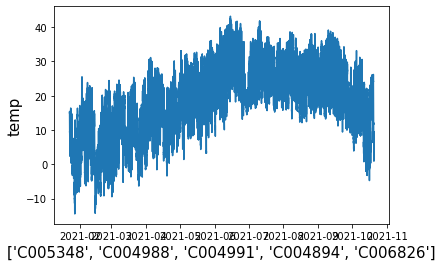

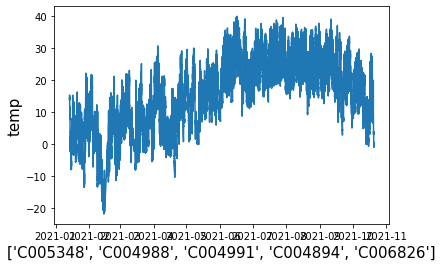

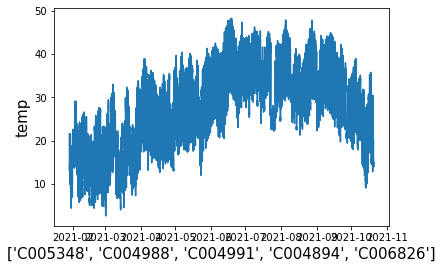

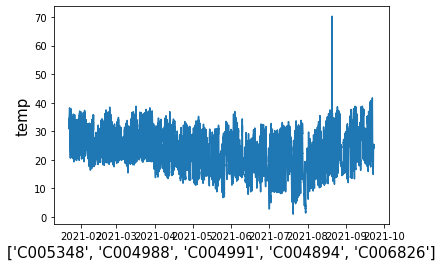

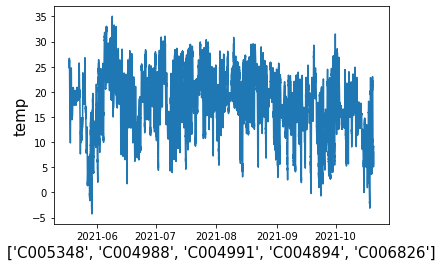

In [21]:
#let's plot data in batch to QC
def quick_look(df, cat_name, cats, props):
    '''
    plot all property:props plots by cats:category
    '''
    for cat in cats:
        fig, ax = plt.subplots()
        plt.plot(df[df[cat_name]==cat][props])
        ax.set_xlabel(cats, fontsize=15)
        ax.set_ylabel(props, fontsize=15)
quick_look(df, 'device', cats, 'temp')

***Note**: there are some outlier 60C C004894 ?

### some outlier plots

In [22]:
def plot_temps(df, device, prop):
    '''
    input dataframe, category(such as devices)
    property(such as temprature)
    '''
    
    plt.plot(df[df.device==device][prop])
    ax.set_xlabel( device, fontsize=15)
    ax.set_ylabel(prop, fontsize=15)



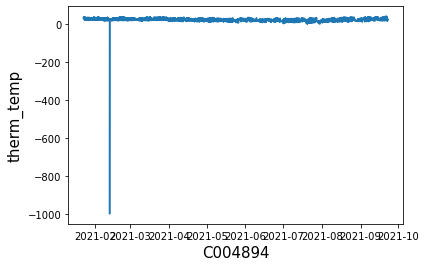

In [23]:
# capture some outliers plots
fig, ax = plt.subplots()
plot_temps(df,'C004894','therm_temp')


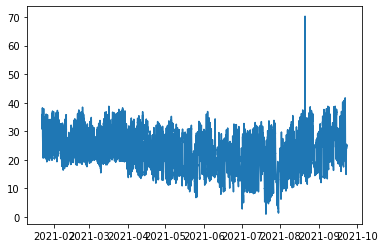

In [24]:
plot_temps(df,'C004894','temp' )

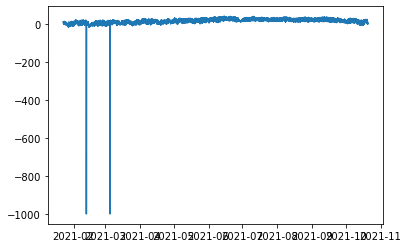

In [25]:
plot_temps(df,'C005348','therm_temp' )

In [26]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)

    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range

    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
#     print(q1, q3, fence_low,fence_high)
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [27]:
#remove outliers simplified approach. could you 3 sigma approach. After tested no difference in this dataset
#outlier handling should be build in pipeline to streamline for deployment
float_v_outliers=['temp', 'temp_sd', 'therm_temp', 'therm_temp_sd', 'p', 't_u14']
for feature in float_v_outliers:
    df = remove_outlier(df, feature)
    




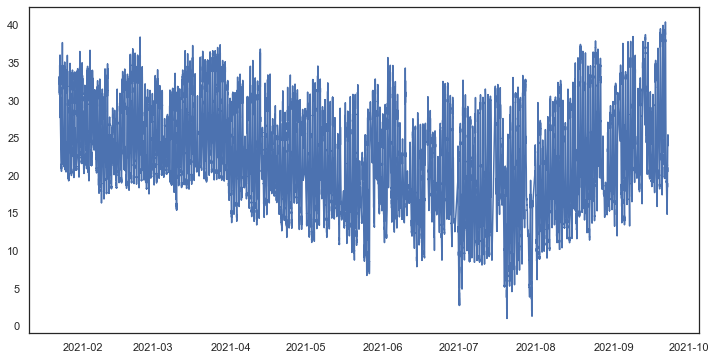

In [81]:
plot_temps(df,'C004894','temp' )

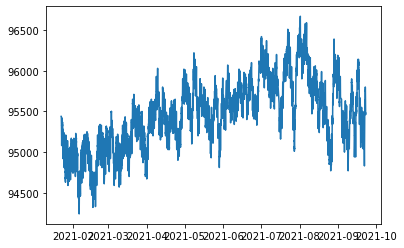

In [28]:
plt.plot(df[df.device=='C004894']['p'])

#### after removed outlier

### Uni Variate Analysis


### plot histograms for quick look

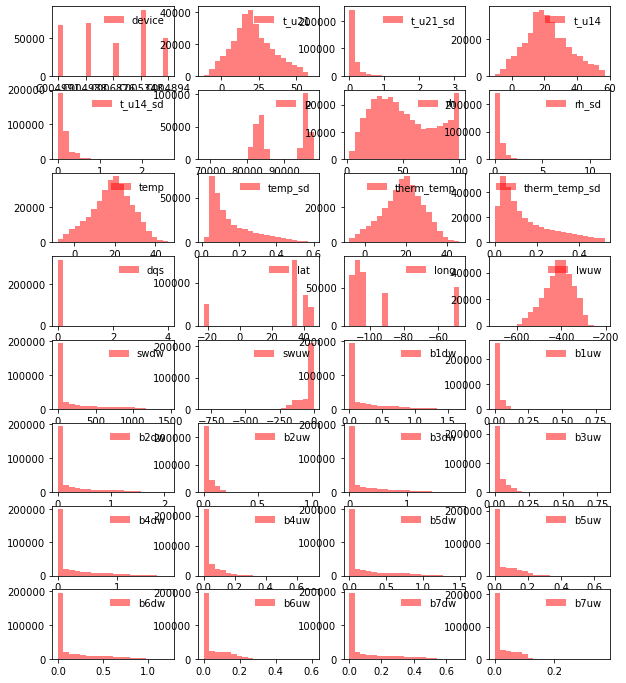

In [29]:
ncols = 4
# nrows=2
nrows = int(np.ceil(len(df.columns) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12))

# Lazy counter so we can remove unwated axes
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(df.columns):

            ax.hist(df[df.columns[counter]], bins=20, color='red', alpha=0.5, label='{}'.format(df.columns[counter]))
#             ax.set_xlabel('x')
#             ax.set_ylabel('PDF')
#             ax.set_ylim([0, 5])
            leg = ax.legend(loc='upper right')
            leg.draw_frame(False)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()

### boxplot  for quick look

<AxesSubplot:>

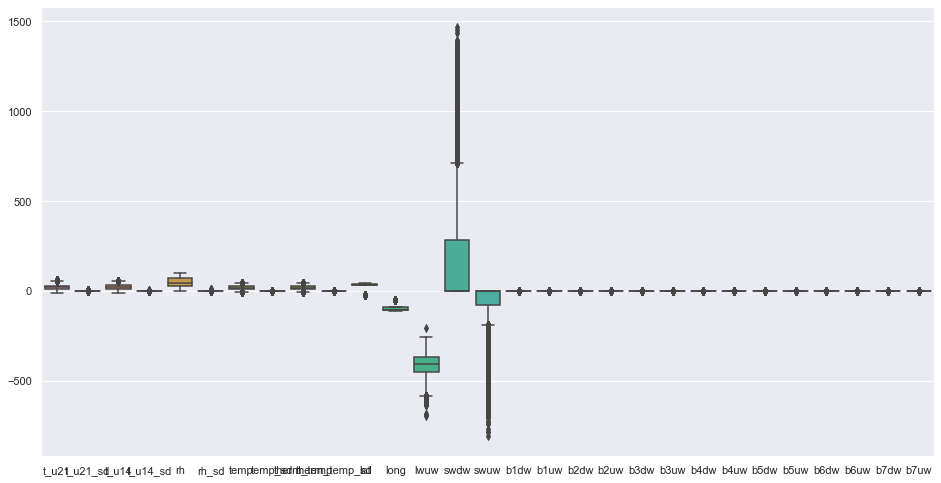

In [30]:
sns.set(rc={'figure.figsize':(16,8.27)})
fig.tight_layout()
# float_v.remove('lwdw')
float_v.remove('p')

sns.boxplot(data=df[float_v])

***Note:*** lwuw, swdw, swuw still has significant outliers

### Independent variables

In [31]:
df_ref=pd.read_csv('reference_data.csv')

In [32]:
#create a dictionary to map site with device

devSite={'AZ_LTER': 'C004991',
 'NREL': 'C004988',
 'ESALQ': 'C004894',
 'US-Los': 'C006826',
 'US-Seg': 'C005348'}

#### create new column device in reference df

In [33]:
df_ref['device']=df_ref.site_id.apply(lambda x: devSite[x] if x in devSite else x )

#### convert types: time, object

In [34]:
df_ref.ref_time = pd.to_datetime(df_ref.ref_time, errors='coerce')
df_ref.device=pd.Categorical(df_ref.device)
df_ref.site_id=pd.Categorical(df_ref.site_id)

In [35]:
df_ref.rename(columns={'ref_time':'time'}, inplace=True)

In [36]:
df_ref.set_index('time', inplace=True)

In [37]:
df_ref_copy=df_ref.copy()

In [38]:
# df_ref_copy.groupby('device').resample('D')['ref_tair'].mean()

In [39]:
# # df_ref_copy.ref_tair.plot()
# fig = plt.figure(figsize=(12,4)) 

# sns.lineplot(data=df_ref_copy.ref_tair, color='blue', linewidth=1)

### Join Mark Data and Reference Data

#### join mark data and df_ref using device and time to create training data

In [40]:
df_copy=df.copy()
#this step is time consuming activate when necessary
# df_new=pd.merge(df_ref, df_copy,  how='right', on=['time','device'])
#https://towardsdatascience.com/how-to-merge-not-matching-time-series-with-pandas-7993fcbce063
df_ref = df_ref.sort_values(['time'])
df_copy = df_copy.sort_values(['time'])
df_new=pd.merge_asof(df_ref, df_copy,  on='time', by='device',tolerance=pd.Timedelta('10min'))

In [41]:
# df_new.info()
df_ref.shape, df_new.shape, df_copy.shape

((2079410, 3), (2079410, 35), (317723, 32))

***Note:*** 
1. after couple tests, choose merge_asof to resolve the time sampling difference when grouping. The tolerance of 10mins is a reasonable assumption.
2. compare to previously only 5000 left after merge, looks like we are able to get most data matched and assigned. lets remove nulls

In [42]:
pd.set_option('display.max_columns', None)
# more options can be specified also
df_new1=df_new[~df_new['ref_tair'].isnull()& ~df_new['temp'].isnull()]

In [43]:
df_new1.set_index('time', inplace=True)

In [44]:

df_new1.describe()

,ref_tair,t_u21,t_u21_sd,t_u14,t_u14_sd,p,rh,rh_sd,temp,temp_sd,therm_temp,therm_temp_sd,lat,long,lwuw,swdw,swuw,b1dw,b1uw,b2dw,b2uw,b3dw,b3uw,b4dw,b4uw,b5dw,b5uw,b6dw,b6uw,b7dw,b7uw
count,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06,1.746586e+06
mean,1.757879e+01,2.116375e+01,1.516680e-01,2.185552e+01,1.410947e-01,8.920156e+04,5.955590e+01,5.274669e-01,1.799518e+01,1.724157e-01,1.805277e+01,1.561268e-01,1.913188e+01,-8.408606e+01,-4.078653e+02,2.095039e+02,-4.179270e+01,2.140242e-01,1.725481e-02,2.842106e-01,2.861608e-02,2.483774e-01,2.868796e-02,2.345071e-01,2.861520e-02,1.893258e-01,4.712459e-02,1.648245e-01,5.062116e-02,9.096366e-02,2.455342e-02
std,8.816387e+00,1.380261e+01,2.020096e-01,1.348791e+01,2.108851e-01,6.822187e+03,2.584099e+01,4.731567e-01,9.220103e+00,1.311879e-01,9.193427e+00,1.318569e-01,2.991602e+01,2.652067e+01,5.978028e+01,3.162305e+02,6.258236e+01,3.272995e-01,3.864383e-02,4.325335e-01,5.557712e-02,3.775271e-01,4.926032e-02,3.632988e-01,4.896548e-02,2.922650e-01,6.888904e-02,2.469501e-01,7.069464e-02,1.389256e-01,3.545950e-02
min,-1.026000e+01,-1.131000e+01,5.524000e-03,-1.023000e+01,0.000000e+00,6.812000e+04,2.172000e+00,0.000000e+00,-8.114000e+00,1.066000e-02,-7.761000e+00,0.000000e+00,-2.270317e+01,-1.119431e+02,-6.978745e+02,9.198386e-02,-8.060849e+02,4.263981e-04,6.590306e-05,2.170858e-04,-2.709746e-05,4.546413e-05,3.024524e-04,4.000740e-05,-2.890000e-05,0.000000e+00,1.569388e-04,1.393463e-04,0.000000e+00,6.652410e-05,-2.194660e-05
25%,1.272000e+01,1.244000e+01,5.349000e-02,1.350000e+01,0.000000e+00,8.211000e+04,3.773000e+01,1.984000e-01,1.277000e+01,6.942000e-02,1.281000e+01,5.114000e-02,-2.270308e+01,-1.051783e+02,-4.451504e+02,9.012966e-01,-7.808691e+01,2.206655e-03,2.330317e-03,1.081977e-03,9.731172e-04,1.524815e-03,1.659203e-03,7.896161e-04,9.203624e-04,7.345789e-04,7.613354e-04,2.254436e-03,2.053849e-03,7.687481e-04,6.321451e-04
50%,1.876000e+01,1.912000e+01,8.013000e-02,2.000000e+01,0.000000e+00,9.480000e+04,5.722000e+01,3.805000e-01,1.890000e+01,1.197000e-01,1.897000e+01,1.073000e-01,3.974211e+01,-1.051782e+02,-4.034933e+02,3.430802e+00,-1.270059e+00,5.222097e-03,3.110636e-03,5.345437e-03,1.451890e-03,4.339837e-03,2.324479e-03,3.169976e-03,1.440338e-03,2.950279e-03,1.324623e-03,3.423262e-03,3.274689e-03,1.620285e-03,9.143032e-04
75%,2.361000e+01,2.949000e+01,1.678000e-01,3.048000e+01,2.445000e-01,9.568000e+04,8.394000e+01,7.259000e-01,2.429000e+01,2.468000e-01,2.433000e+01,2.375000e-01,3.974213e+01,-4.762345e+01,-3.673138e+02,3.448109e+02,-7.829247e-01,3.405909e-01,2.214778e-02,4.583849e-01,4.628304e-02,4.036211e-01,4.822167e-02,3.713630e-01,4.481511e-02,2.995428e-01,8.533692e-02,2.697996e-01,9.352459e-02,1.452131e-01,4.515733e-02
max,4.567000e+01,6.175000e+01,2.924000e+00,5.712000e+01,2.515000e+00,9.812000e+04,1.000000e+02,1.159000e+01,4.629000e+01,5.998000e-01,4.617000e+01,5.226000e-01,4.608366e+01,-4.762338e+01,-2.535588e+02,1.467870e+03,6.023025e-02,1.672999e+00,8.176583e-01,2.075953e+00,1.020749e+00,1.895810e+00,8.045078e-01,1.850926e+00,7.115161e-01,1.487289e+00,6.645489e-01,1.223164e+00,6.112533e-01,6.805988e-01,3.712042e-01


In [45]:
df_new1.shape

(1746586, 34)

#### First pass, We miss some portion (15%) of data during merging even though we tried timedelta approach! We could discuss with customer see if that is acceptable

#### We may want to revisit before deadline. Now let's move on!

In [46]:
#df_new1.describe()
#df_new1.info()
# df_new1.isnull().sum()

In [47]:
df_new1.columns
#group data by categories for later modeling
float_v = list(df_new1.select_dtypes(include=['float64']).columns)
cat_v = list(df_new1.select_dtypes(include=['category']).columns)
cat_v

['site_id', 'device', 'dqs']

### Bivariate Analysis

#### Let's create a heatmap to check dependent and independent variables relationship 

<ipython-input-48-b9ebb6b5073b>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

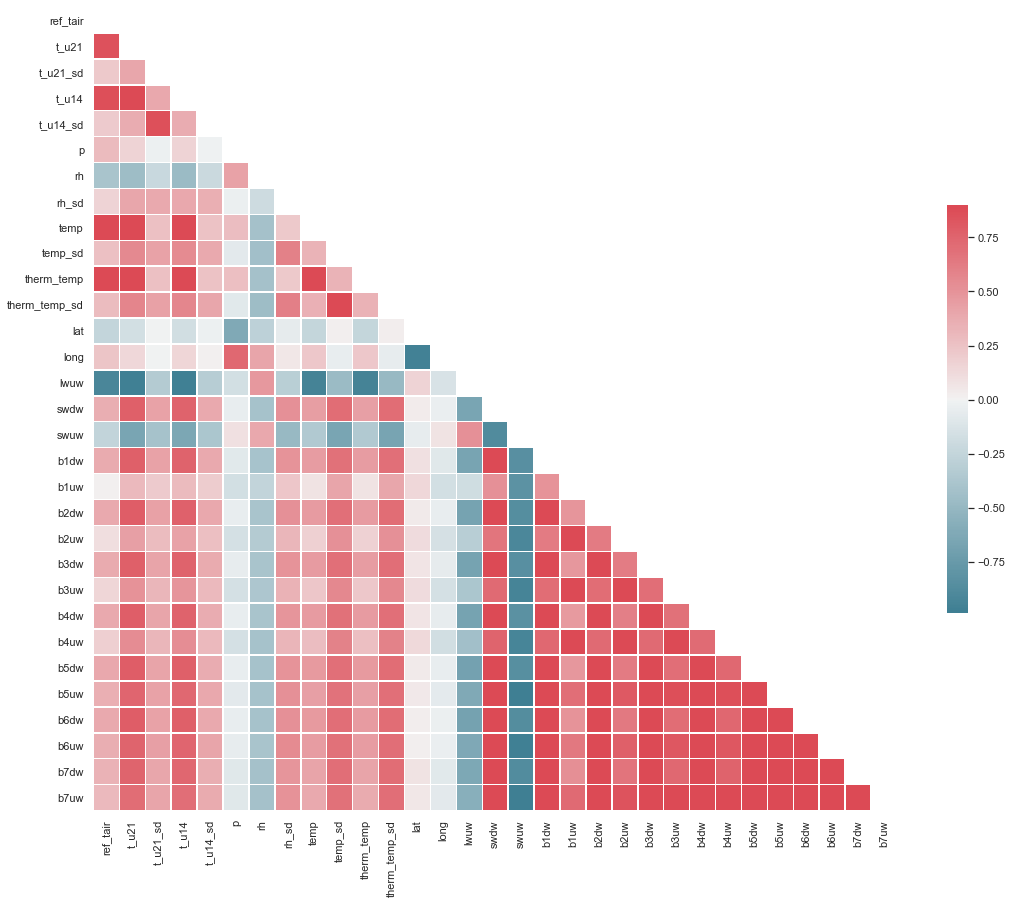

In [48]:
# printmd('**independent and dependent variables, which features have high correlation with dependent var. and how about colinearlity?**')
sns.set(style="white")
features=float_v
corr = df_new1[features].corr()

#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, annot=False, 
square=True, linewidths=.5, cbar_kws={"shrink": .5})

***Note:*** More details on final report
1. very strong colinearalities amond bxdw features
2. strong colinearlities among temprature measurements
3. colinearlity should be handled at modeling stage
4. reference temprature has strong correlation with temp, therm_temp, lwuw,swuw, t_u14, t_u21

# 1. Dummy Transformer for Categorical Data


In [49]:
#since site_id and device are one to one match, we can drop device
df_new1.drop(['device'],axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [50]:
df_new1.shape

(1746586, 33)

In [51]:

# cat_v.remove('device')
cat_features=['site_id', 'dqs']
df_new1 = pd.get_dummies(df_new1, columns=cat_features, drop_first=True)

In [52]:
df_new1.head()

,ref_tair,t_u21,t_u21_sd,t_u14,t_u14_sd,p,rh,rh_sd,temp,temp_sd,therm_temp,therm_temp_sd,lat,long,lwuw,swdw,swuw,b1dw,b1uw,b2dw,b2uw,b3dw,b3uw,b4dw,b4uw,b5dw,b5uw,b6dw,b6uw,b7dw,b7uw,site_id_ESALQ,site_id_NREL,site_id_US-Los,site_id_US-Seg,dqs_4
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-13 20:02:00+00:00,14.53,14.7,0.09079,15.7,0.2449,81190.0,33.47,0.1385,14.46,0.09415,14.57,0.08527,39.74211,-105.17825,-380.56436,52.247845,-12.617517,0.043263,0.004726,0.058777,0.008591,0.051683,0.008254,0.044487,0.008498,0.038852,0.010727,0.040126,0.012831,0.022448,0.006387,0,1,0,0,0
2021-01-13 20:02:00+00:00,14.53,14.7,0.09079,15.7,0.2449,81190.0,33.47,0.1385,14.46,0.09415,14.57,0.08527,39.74211,-105.17825,-380.56436,52.247845,-12.617517,0.043263,0.004726,0.058777,0.008591,0.051683,0.008254,0.044487,0.008498,0.038852,0.010727,0.040126,0.012831,0.022448,0.006387,0,1,0,0,0
2021-01-13 20:03:00+00:00,14.55,14.7,0.09079,15.7,0.2449,81190.0,33.47,0.1385,14.46,0.09415,14.57,0.08527,39.74211,-105.17825,-380.56436,52.247845,-12.617517,0.043263,0.004726,0.058777,0.008591,0.051683,0.008254,0.044487,0.008498,0.038852,0.010727,0.040126,0.012831,0.022448,0.006387,0,1,0,0,0
2021-01-13 20:03:00+00:00,14.55,14.7,0.09079,15.7,0.2449,81190.0,33.47,0.1385,14.46,0.09415,14.57,0.08527,39.74211,-105.17825,-380.56436,52.247845,-12.617517,0.043263,0.004726,0.058777,0.008591,0.051683,0.008254,0.044487,0.008498,0.038852,0.010727,0.040126,0.012831,0.022448,0.006387,0,1,0,0,0
2021-01-13 20:04:00+00:00,14.53,14.7,0.09079,15.7,0.2449,81190.0,33.47,0.1385,14.46,0.09415,14.57,0.08527,39.74211,-105.17825,-380.56436,52.247845,-12.617517,0.043263,0.004726,0.058777,0.008591,0.051683,0.008254,0.044487,0.008498,0.038852,0.010727,0.040126,0.012831,0.022448,0.006387,0,1,0,0,0


In [53]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Regression

#### random split to train test data

In [113]:

# features
features=df_new1.columns.tolist()
target='ref_tair'
features.remove(target)


In [114]:
features=df_new1.columns.tolist()
target='ref_tair'
features.remove(target)
X=df_new1[features]
y=df_new1[target]

# split into train/test sets with same class ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                     random_state=42)


In [115]:
X_train.shape

(1222610, 36)

#### Build Pipeline

In [121]:
steps=[('rescale', StandardScaler()),
#        ('pca', PCA(n_components=10)), #StandardScaler, RobustScaler
       ('lr', Lasso(alpha=5, max_iter=100000))]
#        ('rfr', RandomForestRegressor(n_jobs=-1, random_state=0))]
lasso_pipe=Pipeline(steps)
lasso_pipe = lasso_pipe.fit(X_train, y_train)

In [122]:
y_train_pred=lasso_pipe.predict(X_train)
y_test_pred=lasso_pipe.predict(X_test)

#### Train Test Results

In [123]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 3.94e+00
train MSE: 2.50e+01
train R2: 0.678
test MAE: 3.95e+00
test MSE: 2.51e+01
test R2: 0.678


#### Note: reasonable good result, see if we can do better

# 2. Random Forest

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### random split to train test data

In [54]:

# features
features=df_new1.columns.tolist()
target='ref_tair'
features.remove(target)


In [55]:
features=df_new1.columns.tolist()
target='ref_tair'
features.remove(target)
X=df_new1[features]
y=df_new1[target]

# split into train/test sets with same class ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                     random_state=42)


In [56]:
X_train.shape

(1222610, 35)

#### Build Pipeline

In [58]:
steps=[('rescale', StandardScaler()),
#        ('pca', PCA(n_components=10)), #StandardScaler, RobustScaler
#        ('lr', Lasso(alpha=1, max_iter=100000))]
       ('rfr', RandomForestRegressor(n_jobs=-1, random_state=0))]
rf_pipe=Pipeline(steps)
rf_pipe = rf_pipe.fit(X_train, y_train)

In [59]:
y_train_pred=rf_pipe.predict(X_train)
y_test_pred=rf_pipe.predict(X_test)

#### Train Test Results

In [60]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 8.20e-02
train MSE: 2.24e-02
train R2: 1.000
test MAE: 1.09e-01
test MSE: 5.63e-02
test R2: 0.999


***Note: Almost perfect prediction*** 
\
use Randomforrest. Are there information leaking? Need to check

<AxesSubplot:>

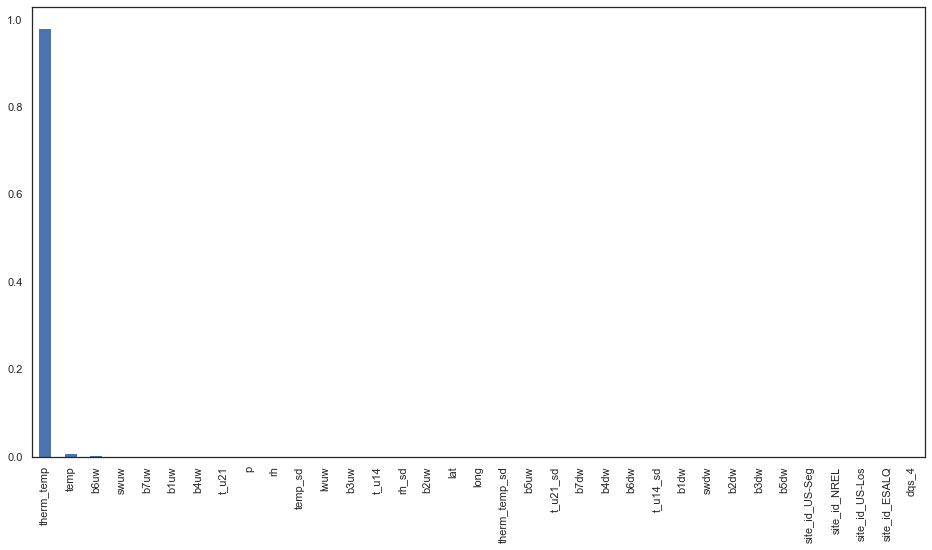

In [62]:
feat_importances = pd.Series(rf_pipe.steps[1][1].feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).plot(kind='bar')

***Note*** 
\
Two biggest hitters are two temperature, which is not surprising, due to strong colinearlity

# Understand Colinearlity: PCA component sensitivity

In [63]:

# features
features=df_new1.columns.tolist()
target='ref_tair'
features.remove(target)


In [64]:
features=df_new1.columns.tolist()
target='ref_tair'
features.remove(target)
X=df_new1[features]
y=df_new1[target]

# split into train/test sets with same class ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                     random_state=42)


#### Build Pipeline

In [67]:
steps=[('rescale', StandardScaler()),
       ('pca', PCA(n_components=35))] #StandardScaler, RobustScaler
#        ('lr', Lasso(alpha=1, max_iter=100000))]
#        ('rfr', RandomForestRegressor(n_jobs=-1, random_state=0))]
pcapipe=Pipeline(steps)
pcapipe = pcapipe.fit(X_train, y_train)

In [68]:
pca=pcapipe.steps[1][1].fit(X_train, y_train)

In [69]:
pca.explained_variance_ratio_

array([9.97663076e-01, 2.24528908e-03, 4.81735613e-05, 1.83448826e-05,
       1.78466474e-05, 6.52672844e-06, 4.63331794e-07, 2.12779392e-07,
       5.50262994e-08, 5.19197326e-09, 3.32178238e-09, 1.27443038e-09,
       1.20733213e-09, 2.61175164e-10, 2.38032105e-10, 2.02236530e-10,
       1.24936585e-10, 2.27592912e-11, 2.15856393e-11, 1.53719006e-11,
       1.49970810e-11, 1.10640874e-11, 6.96035006e-12, 5.44197873e-12,
       3.29858358e-12, 2.04560801e-12, 1.08651962e-12, 8.37019206e-13,
       5.37956110e-13, 1.06305049e-13, 6.69462606e-14, 3.18828201e-14,
       2.09980970e-14, 1.54841261e-19, 1.32179310e-20])

#### The number of components needed to explain variance

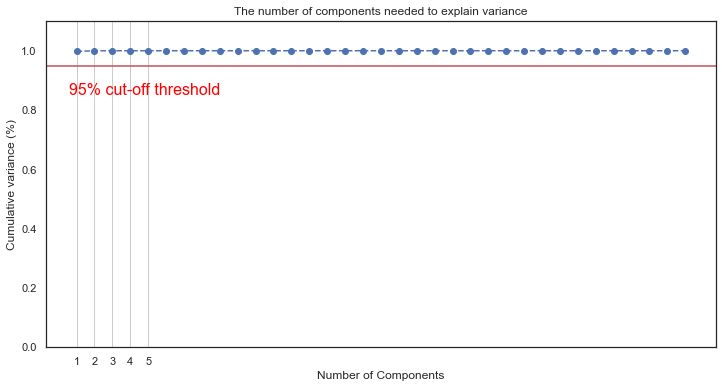

In [70]:
#https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
import numpy as np
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 36, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 6, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.55, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### Almost Perfect R2, let's plot y_test_predict vs. y_test

[(-10.0, 50.0), (-10.0, 50.0)]

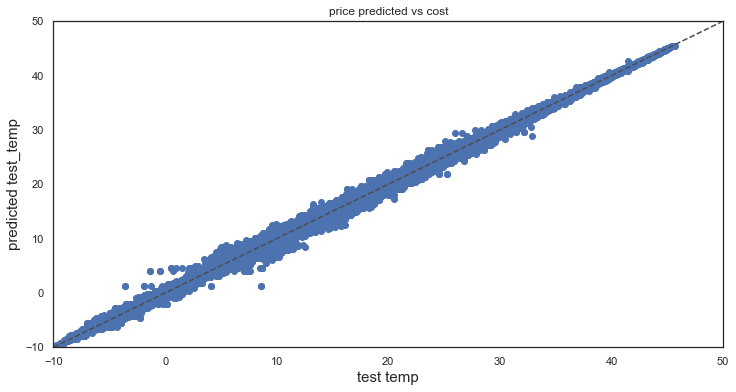

In [71]:
fig, ax = plt.subplots()
plt.scatter(y_train, y_train_pred)

ax.set_xlabel(r'test temp', fontsize=15)
ax.set_ylabel(r'predicted test_temp', fontsize=15)
ax.set_title('price predicted vs cost')

ax.plot([-10, 50], [-10, 50], ls="--", c=".3")
ax.set(xlim=(-10, 50), ylim=(-10, 50))

### Predict y

In [73]:
X_all=df_new1.iloc[:, 1:]
X_all.shape

(1746586, 35)

In [74]:
df_new1['temp_pred']=rf_pipe.predict(X_all)

### Prediction QC

In [99]:
df_new1.head()

,ref_tair,t_u21,t_u21_sd,t_u14,t_u14_sd,p,rh,rh_sd,temp,temp_sd,therm_temp,therm_temp_sd,lat,long,lwuw,swdw,swuw,b1dw,b1uw,b2dw,b2uw,b3dw,b3uw,b4dw,b4uw,b5dw,b5uw,b6dw,b6uw,b7dw,b7uw,site_id_ESALQ,site_id_NREL,site_id_US-Los,site_id_US-Seg,dqs_4,temp_pred
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-13 20:02:00+00:00,14.53,14.7,0.09079,15.7,0.2449,81190.0,33.47,0.1385,14.46,0.09415,14.57,0.08527,39.74211,-105.17825,-380.56436,52.247845,-12.617517,0.043263,0.004726,0.058777,0.008591,0.051683,0.008254,0.044487,0.008498,0.038852,0.010727,0.040126,0.012831,0.022448,0.006387,0,1,0,0,0,14.536569
2021-01-13 20:02:00+00:00,14.53,14.7,0.09079,15.7,0.2449,81190.0,33.47,0.1385,14.46,0.09415,14.57,0.08527,39.74211,-105.17825,-380.56436,52.247845,-12.617517,0.043263,0.004726,0.058777,0.008591,0.051683,0.008254,0.044487,0.008498,0.038852,0.010727,0.040126,0.012831,0.022448,0.006387,0,1,0,0,0,14.536569
2021-01-13 20:03:00+00:00,14.55,14.7,0.09079,15.7,0.2449,81190.0,33.47,0.1385,14.46,0.09415,14.57,0.08527,39.74211,-105.17825,-380.56436,52.247845,-12.617517,0.043263,0.004726,0.058777,0.008591,0.051683,0.008254,0.044487,0.008498,0.038852,0.010727,0.040126,0.012831,0.022448,0.006387,0,1,0,0,0,14.536569
2021-01-13 20:03:00+00:00,14.55,14.7,0.09079,15.7,0.2449,81190.0,33.47,0.1385,14.46,0.09415,14.57,0.08527,39.74211,-105.17825,-380.56436,52.247845,-12.617517,0.043263,0.004726,0.058777,0.008591,0.051683,0.008254,0.044487,0.008498,0.038852,0.010727,0.040126,0.012831,0.022448,0.006387,0,1,0,0,0,14.536569
2021-01-13 20:04:00+00:00,14.53,14.7,0.09079,15.7,0.2449,81190.0,33.47,0.1385,14.46,0.09415,14.57,0.08527,39.74211,-105.17825,-380.56436,52.247845,-12.617517,0.043263,0.004726,0.058777,0.008591,0.051683,0.008254,0.044487,0.008498,0.038852,0.010727,0.040126,0.012831,0.022448,0.006387,0,1,0,0,0,14.536569


<AxesSubplot:xlabel='time'>

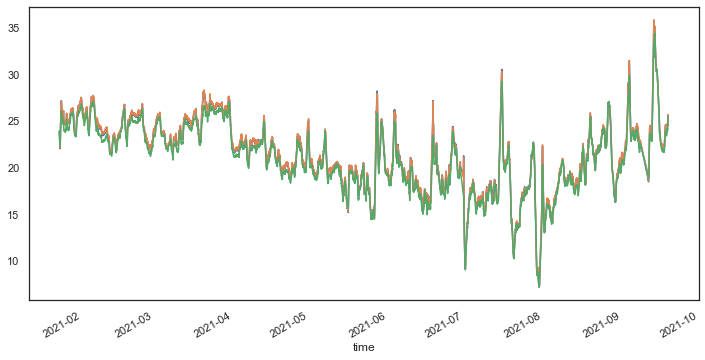

In [101]:

df_new1[df_new1['site_id_ESALQ']==1].temp.rolling('1D').mean().plot()
df_new1[df_new1['site_id_ESALQ']==1].therm_temp.rolling('1D').mean().plot()
df_new1[df_new1['site_id_ESALQ']==1].temp_pred.rolling('1D').mean().plot()


In [133]:
#### Reasonbale good match of prediction and refernce T

<AxesSubplot:xlabel='time'>

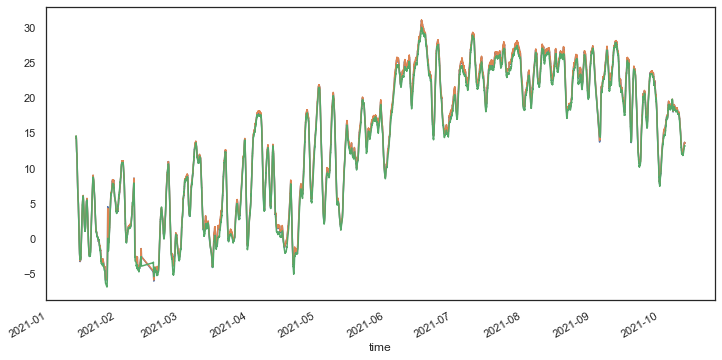

In [102]:

df_new1[df_new1['site_id_NREL']==1].temp.rolling('1D').mean().plot()
df_new1[df_new1['site_id_NREL']==1].therm_temp.rolling('1D').mean().plot()
df_new1[df_new1['site_id_NREL']==1].temp_pred.rolling('1D').mean().plot()


<AxesSubplot:xlabel='time'>

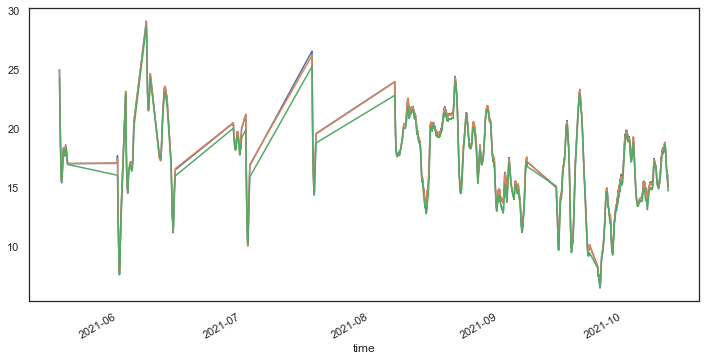

In [103]:

df_new1[df_new1['site_id_US-Los']==1].temp.rolling('1D').mean().plot()
df_new1[df_new1['site_id_US-Los']==1].therm_temp.rolling('1D').mean().plot()
df_new1[df_new1['site_id_US-Los']==1].temp_pred.rolling('1D').mean().plot()


#### problematic data due to merging. Need to investigate later